In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
import random
random.seed(12)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

from tqdm import tqdm

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
from torch.utils.data import Dataset
from torchvision import transforms
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import cv2

import math

from pytorch_metric_learning import losses, miners, distances, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

In [3]:
class FERDataset(Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, dff, transforms):
        'Initialization'
        self.transforms = transforms
        self.dff= pd.read_csv(dff) if type(dff) is str else dff
        
        self.dff['pixels'] = [[int(y) for y in x.split()] for x in self.dff['pixels']]

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.dff)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        #ID = self.list_IDs[index]

        # Load data and get label
        X = self.dff.iloc[index]['pixels']
#         X = X.split()
        X = np.array(X, dtype=np.uint8)
        X = X.reshape(48,48)
        
        y = int(self.dff.iloc[index]['emotion'])

        if self.transforms:
            X = self.transforms(image=X)['image']

#             X = torch.cat((X,X,X),0)

        return X, y

In [4]:
batch_size= 64

df = pd.read_csv('/tf/data/Quan/fer2013/data/csv_file/fer2013.csv')

df_train = df[df['Usage'] == 'Training']
df_val = df[df['Usage'] == 'PublicTest']
df_test = df[df['Usage'] == 'PrivateTest']


train_transforms = A.Compose([
#     A.CLAHE(),
    A.Resize(64,64),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=10, p=0.5, border_mode=0, value=0),
#     A.RandomCrop(height=40, width=40),
    A.Normalize(mean=(0.485,), std=(0.229,)),
    ToTensorV2()
])


test_transforms = A.Compose([
#     A.CLAHE(),
    A.Resize(64,64),
    A.Normalize(mean=(0.485,), std=(0.229,)),
    ToTensorV2()
])

train_set = FERDataset(df_train, train_transforms)
val_set = FERDataset(df_val, test_transforms)
test_set = FERDataset(df_test, test_transforms)


train_loader = torch.utils.data.DataLoader(train_set,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)
val_loader = torch.utils.data.DataLoader(val_set,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=8)
test_loader = torch.utils.data.DataLoader(test_set,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=8)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Simple VGG

In [5]:
class VGG(nn.Module):
    def __init__(self, in_channels=1, out_channels=7):
        
        super(VGG, self).__init__()
        self.block1a = nn.Sequential(nn.Conv2d(in_channels, 32, kernel_size=(3,3)),
                                     nn.BatchNorm2d(32),
                                     nn.ReLU(inplace=True))
        self.block1b = nn.Sequential(nn.Conv2d(32, 32, kernel_size=(3,3)),
                                     nn.BatchNorm2d(32),
                                     nn.ReLU(inplace=True))
        
        self.block2a = nn.Sequential(nn.Conv2d(32, 64, kernel_size=(3,3)),
                                     nn.BatchNorm2d(64),
                                     nn.ReLU(inplace=True))
        self.block2b = nn.Sequential(nn.Conv2d(64, 64, kernel_size=(3,3)),
                                     nn.BatchNorm2d(64),
                                     nn.ReLU(inplace=True))
        
        self.block3a = nn.Sequential(nn.Conv2d(64, 128, kernel_size=(3,3)),
                                     nn.BatchNorm2d(128),
                                     nn.ReLU(inplace=True))
        self.block3b = nn.Sequential(nn.Conv2d(128, 128, kernel_size=(3,3)),
                                     nn.BatchNorm2d(128),
                                     nn.ReLU(inplace=True))
        
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(nn.Linear(128, 128),
                                        nn.BatchNorm1d(128),
                                        nn.ReLU(),
                                        nn.Linear(128,out_channels))
        
    def forward(self, x):
        x = self.block1a(x)
        x = self.block1b(x)
        
        x = self.maxpool(x)
        
        x = self.block2a(x)
        x = self.block2b(x)
        
        x = self.maxpool(x)
        
        x = self.block3a(x)
        x = self.block3b(x)
        
        x_feature = self.maxpool(x)
        
        x = self.avgpool(x_feature)
        x = self.flatten(x)
        x = self.classifier(x)
        
        return x, x_feature

In [10]:
lr = 0.01
epochs = 100
device = torch.device('cuda')

model = VGG()

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)

best_acc = 0.0
hist = []

In [11]:
MAX_LOGSTD=10
model_path = 'simplenet/VGG_model.pt'
alpha = 1

# optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
for epoch in range(epochs):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, features = model(inputs)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.4f | Avg.acc: %.4f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, features = model(inputs)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.4f | Avg. val_acc: %.4f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalacc)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/449 [00:00<?, ?it/s]

Epoch:  1


Loss=1.7301740646362305 Batch_id=448 Accuracy=0.35135135135135137: 100%|██████████| 449/449 [00:11<00:00, 37.76it/s]

- Avg.loss: 1.7900 | Avg.acc: 0.2586



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.9457 | Avg. val_acc: 0.2586
* Update optimal model
Epoch:  2


Loss=1.4561092853546143 Batch_id=448 Accuracy=0.43243243243243246: 100%|██████████| 449/449 [00:11<00:00, 37.59it/s]

- Avg.loss: 1.6075 | Avg.acc: 0.3570



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.5451 | Avg. val_acc: 0.4099
* Update optimal model
Epoch:  3


Loss=1.543610692024231 Batch_id=448 Accuracy=0.40540540540540543: 100%|██████████| 449/449 [00:12<00:00, 37.35it/s]

- Avg.loss: 1.4175 | Avg.acc: 0.4505



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.4588 | Avg. val_acc: 0.4517
* Update optimal model
Epoch:  4


Loss=1.2637622356414795 Batch_id=448 Accuracy=0.4594594594594595: 100%|██████████| 449/449 [00:11<00:00, 38.08it/s]

- Avg.loss: 1.3300 | Avg.acc: 0.4941



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.3134 | Avg. val_acc: 0.5054
* Update optimal model
Epoch:  5


Loss=1.2798715829849243 Batch_id=448 Accuracy=0.5405405405405406: 100%|██████████| 449/449 [00:11<00:00, 38.14it/s]

- Avg.loss: 1.2892 | Avg.acc: 0.5063



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.3045 | Avg. val_acc: 0.5038
Epoch:  6


Loss=1.145254373550415 Batch_id=448 Accuracy=0.6216216216216216: 100%|██████████| 449/449 [00:11<00:00, 37.59it/s]

- Avg.loss: 1.2568 | Avg.acc: 0.5213



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.3216 | Avg. val_acc: 0.5060
* Update optimal model
Epoch:  7


Loss=1.102082371711731 Batch_id=448 Accuracy=0.5675675675675675: 100%|██████████| 449/449 [00:12<00:00, 37.14it/s]

- Avg.loss: 1.2352 | Avg.acc: 0.5268



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.3282 | Avg. val_acc: 0.5060
Epoch:  8


Loss=0.9285898208618164 Batch_id=448 Accuracy=0.7297297297297297: 100%|██████████| 449/449 [00:12<00:00, 37.20it/s]

- Avg.loss: 1.2156 | Avg.acc: 0.5354



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2453 | Avg. val_acc: 0.5280
* Update optimal model
Epoch:  9


Loss=0.9933305978775024 Batch_id=448 Accuracy=0.5945945945945946: 100%|██████████| 449/449 [00:12<00:00, 37.23it/s]

- Avg.loss: 1.2043 | Avg.acc: 0.5409



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2104 | Avg. val_acc: 0.5216
Epoch:  10


Loss=1.2627090215682983 Batch_id=448 Accuracy=0.5405405405405406: 100%|██████████| 449/449 [00:11<00:00, 37.64it/s]

- Avg.loss: 1.1949 | Avg.acc: 0.5448



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1810 | Avg. val_acc: 0.5500
* Update optimal model
Epoch:  11


Loss=1.5765548944473267 Batch_id=448 Accuracy=0.32432432432432434: 100%|██████████| 449/449 [00:11<00:00, 37.47it/s]

- Avg.loss: 1.1836 | Avg.acc: 0.5513



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2207 | Avg. val_acc: 0.5391
Epoch:  12


Loss=1.4832334518432617 Batch_id=448 Accuracy=0.4594594594594595: 100%|██████████| 449/449 [00:12<00:00, 37.18it/s]

- Avg.loss: 1.1755 | Avg.acc: 0.5551



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1779 | Avg. val_acc: 0.5542
* Update optimal model
Epoch:  13


Loss=1.1588616371154785 Batch_id=448 Accuracy=0.6216216216216216: 100%|██████████| 449/449 [00:11<00:00, 37.92it/s]

- Avg.loss: 1.1667 | Avg.acc: 0.5579



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1983 | Avg. val_acc: 0.5436
Epoch:  14


Loss=1.3200340270996094 Batch_id=448 Accuracy=0.5675675675675675: 100%|██████████| 449/449 [00:11<00:00, 37.55it/s]

- Avg.loss: 1.1599 | Avg.acc: 0.5606



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2397 | Avg. val_acc: 0.5344
Epoch:  15


Loss=1.4415669441223145 Batch_id=448 Accuracy=0.4864864864864865: 100%|██████████| 449/449 [00:11<00:00, 37.62it/s]

- Avg.loss: 1.1479 | Avg.acc: 0.5634



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1894 | Avg. val_acc: 0.5481
Epoch:  16


Loss=1.1317012310028076 Batch_id=448 Accuracy=0.5405405405405406: 100%|██████████| 449/449 [00:11<00:00, 38.08it/s]

- Avg.loss: 1.1496 | Avg.acc: 0.5679



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1465 | Avg. val_acc: 0.5698
* Update optimal model
Epoch:  17


Loss=1.1808058023452759 Batch_id=448 Accuracy=0.5405405405405406: 100%|██████████| 449/449 [00:11<00:00, 37.80it/s]

- Avg.loss: 1.1420 | Avg.acc: 0.5713



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1470 | Avg. val_acc: 0.5726
* Update optimal model
Epoch:  18


Loss=1.0709521770477295 Batch_id=448 Accuracy=0.6216216216216216: 100%|██████████| 449/449 [00:11<00:00, 37.74it/s]

- Avg.loss: 1.1458 | Avg.acc: 0.5650



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1724 | Avg. val_acc: 0.5525
Epoch:  19


Loss=0.931659996509552 Batch_id=448 Accuracy=0.6486486486486487: 100%|██████████| 449/449 [00:11<00:00, 37.74it/s]

- Avg.loss: 1.1432 | Avg.acc: 0.5688



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2282 | Avg. val_acc: 0.5481
Epoch:  20


Loss=1.1659657955169678 Batch_id=448 Accuracy=0.5135135135135135: 100%|██████████| 449/449 [00:11<00:00, 37.86it/s]

- Avg.loss: 1.1393 | Avg.acc: 0.5693



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1463 | Avg. val_acc: 0.5626
Epoch:  21


Loss=1.3282527923583984 Batch_id=448 Accuracy=0.5135135135135135: 100%|██████████| 449/449 [00:11<00:00, 37.79it/s]

- Avg.loss: 1.1354 | Avg.acc: 0.5717



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1887 | Avg. val_acc: 0.5456
Epoch:  22


Loss=0.9562249183654785 Batch_id=448 Accuracy=0.6216216216216216: 100%|██████████| 449/449 [00:11<00:00, 37.59it/s]

- Avg.loss: 1.1307 | Avg.acc: 0.5734



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1658 | Avg. val_acc: 0.5570
Epoch:  23


Loss=1.2233978509902954 Batch_id=448 Accuracy=0.5405405405405406: 100%|██████████| 449/449 [00:11<00:00, 37.78it/s]

- Avg.loss: 1.1320 | Avg.acc: 0.5740



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1178 | Avg. val_acc: 0.5729
* Update optimal model
Epoch:  24


Loss=0.8543294072151184 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:12<00:00, 37.35it/s]

- Avg.loss: 1.1306 | Avg.acc: 0.5727



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1741 | Avg. val_acc: 0.5536
Epoch:  25


Loss=1.098027229309082 Batch_id=448 Accuracy=0.5945945945945946: 100%|██████████| 449/449 [00:11<00:00, 38.14it/s]

- Avg.loss: 1.1244 | Avg.acc: 0.5770



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2228 | Avg. val_acc: 0.5472
Epoch:  26


Loss=0.9837619662284851 Batch_id=448 Accuracy=0.6486486486486487: 100%|██████████| 449/449 [00:11<00:00, 38.63it/s]

- Avg.loss: 1.1318 | Avg.acc: 0.5729



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1422 | Avg. val_acc: 0.5698
Epoch:  27


Loss=1.1030582189559937 Batch_id=448 Accuracy=0.5945945945945946: 100%|██████████| 449/449 [00:11<00:00, 37.82it/s]

- Avg.loss: 1.1253 | Avg.acc: 0.5740



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1132 | Avg. val_acc: 0.5773
* Update optimal model
Epoch:  28


Loss=0.9835212230682373 Batch_id=448 Accuracy=0.5945945945945946: 100%|██████████| 449/449 [00:12<00:00, 37.42it/s]

- Avg.loss: 1.1209 | Avg.acc: 0.5770



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1764 | Avg. val_acc: 0.5344
Epoch:  29


Loss=1.3528637886047363 Batch_id=448 Accuracy=0.4594594594594595: 100%|██████████| 449/449 [00:11<00:00, 38.80it/s]

- Avg.loss: 1.1252 | Avg.acc: 0.5763



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1334 | Avg. val_acc: 0.5709
Epoch:  30


Loss=0.9490529894828796 Batch_id=448 Accuracy=0.6486486486486487: 100%|██████████| 449/449 [00:11<00:00, 38.78it/s]

- Avg.loss: 1.1187 | Avg.acc: 0.5796



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1630 | Avg. val_acc: 0.5556
Epoch:  31


Loss=1.266072392463684 Batch_id=448 Accuracy=0.40540540540540543: 100%|██████████| 449/449 [00:11<00:00, 39.16it/s]

- Avg.loss: 1.1210 | Avg.acc: 0.5774



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2202 | Avg. val_acc: 0.5531
Epoch:  32


Loss=1.3868480920791626 Batch_id=448 Accuracy=0.4864864864864865: 100%|██████████| 449/449 [00:11<00:00, 38.59it/s]

- Avg.loss: 1.1256 | Avg.acc: 0.5764



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1557 | Avg. val_acc: 0.5690
Epoch:  33


Loss=1.2012882232666016 Batch_id=448 Accuracy=0.4864864864864865: 100%|██████████| 449/449 [00:11<00:00, 38.94it/s]

- Avg.loss: 1.1165 | Avg.acc: 0.5826



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1756 | Avg. val_acc: 0.5603
Epoch    33: reducing learning rate of group 0 to 1.0000e-03.
Epoch:  34


Loss=1.1352261304855347 Batch_id=448 Accuracy=0.5675675675675675: 100%|██████████| 449/449 [00:11<00:00, 38.67it/s]

- Avg.loss: 1.0278 | Avg.acc: 0.6147



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0350 | Avg. val_acc: 0.6096
* Update optimal model
Epoch:  35


Loss=0.7667068243026733 Batch_id=448 Accuracy=0.8108108108108109: 100%|██████████| 449/449 [00:11<00:00, 38.82it/s]

- Avg.loss: 0.9967 | Avg.acc: 0.6242



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0292 | Avg. val_acc: 0.6121
* Update optimal model
Epoch:  36


Loss=0.729744553565979 Batch_id=448 Accuracy=0.7297297297297297: 100%|██████████| 449/449 [00:11<00:00, 38.50it/s]

- Avg.loss: 0.9815 | Avg.acc: 0.6329



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0197 | Avg. val_acc: 0.6158
* Update optimal model
Epoch:  37


Loss=0.9274450540542603 Batch_id=448 Accuracy=0.5945945945945946: 100%|██████████| 449/449 [00:11<00:00, 39.39it/s]

- Avg.loss: 0.9722 | Avg.acc: 0.6351



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0202 | Avg. val_acc: 0.6213
* Update optimal model
Epoch:  38


Loss=0.5704004168510437 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:11<00:00, 38.36it/s]

- Avg.loss: 0.9619 | Avg.acc: 0.6397



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0265 | Avg. val_acc: 0.6147
Epoch:  39


Loss=0.9210665822029114 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:11<00:00, 38.77it/s]

- Avg.loss: 0.9515 | Avg.acc: 0.6466



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0179 | Avg. val_acc: 0.6202
Epoch:  40


Loss=1.1120766401290894 Batch_id=448 Accuracy=0.5675675675675675: 100%|██████████| 449/449 [00:11<00:00, 38.84it/s]

- Avg.loss: 0.9172 | Avg.acc: 0.6581



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0203 | Avg. val_acc: 0.6213
Epoch:  46


Loss=0.9563571810722351 Batch_id=448 Accuracy=0.5675675675675675: 100%|██████████| 449/449 [00:11<00:00, 38.86it/s]

- Avg.loss: 0.9127 | Avg.acc: 0.6583



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0237 | Avg. val_acc: 0.6230
Epoch:  47


Loss=0.940449059009552 Batch_id=448 Accuracy=0.6756756756756757: 100%|██████████| 449/449 [00:11<00:00, 38.79it/s]

- Avg.loss: 0.9067 | Avg.acc: 0.6604



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0202 | Avg. val_acc: 0.6241
Epoch    47: reducing learning rate of group 0 to 1.0000e-04.
Epoch:  48


Loss=1.0415290594100952 Batch_id=448 Accuracy=0.5135135135135135: 100%|██████████| 449/449 [00:11<00:00, 38.46it/s]

- Avg.loss: 0.8897 | Avg.acc: 0.6685



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0137 | Avg. val_acc: 0.6261
* Update optimal model
Epoch:  49


Loss=0.927455484867096 Batch_id=448 Accuracy=0.6486486486486487: 100%|██████████| 449/449 [00:11<00:00, 38.48it/s]

- Avg.loss: 0.8776 | Avg.acc: 0.6735



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0117 | Avg. val_acc: 0.6225
Epoch:  50


Loss=1.0718532800674438 Batch_id=448 Accuracy=0.5675675675675675: 100%|██████████| 449/449 [00:11<00:00, 38.63it/s]

- Avg.loss: 0.8750 | Avg.acc: 0.6737



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0159 | Avg. val_acc: 0.6289
* Update optimal model
Epoch:  51


Loss=1.093002200126648 Batch_id=87 Accuracy=0.5625:  18%|█▊        | 83/449 [00:02<00:09, 39.39it/s]   IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=0.7858729958534241 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:11<00:00, 38.89it/s]

- Avg.loss: 0.8611 | Avg.acc: 0.6783



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0245 | Avg. val_acc: 0.6239
Epoch:  65


Loss=0.8595288395881653 Batch_id=448 Accuracy=0.5945945945945946: 100%|██████████| 449/449 [00:11<00:00, 38.21it/s]

- Avg.loss: 0.8597 | Avg.acc: 0.6812



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0214 | Avg. val_acc: 0.6222
Epoch:  66


Loss=0.7327653169631958 Batch_id=448 Accuracy=0.6216216216216216: 100%|██████████| 449/449 [00:11<00:00, 39.11it/s]

- Avg.loss: 0.8599 | Avg.acc: 0.6810



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0230 | Avg. val_acc: 0.6250
Epoch:  67


Loss=0.6649361252784729 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:11<00:00, 38.50it/s]

- Avg.loss: 0.8601 | Avg.acc: 0.6803



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0224 | Avg. val_acc: 0.6264
Epoch    67: reducing learning rate of group 0 to 1.0000e-06.
Epoch:  68


Loss=0.7779999375343323 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:11<00:00, 38.45it/s]

- Avg.loss: 0.8570 | Avg.acc: 0.6826



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0233 | Avg. val_acc: 0.6283
Epoch:  69


Loss=1.1065537929534912 Batch_id=448 Accuracy=0.6486486486486487: 100%|██████████| 449/449 [00:11<00:00, 38.21it/s]

- Avg.loss: 0.8608 | Avg.acc: 0.6808



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0202 | Avg. val_acc: 0.6250
Epoch:  70


Loss=0.9629746675491333 Batch_id=2 Accuracy=0.671875:   0%|          | 1/449 [00:00<03:15,  2.30it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=0.7605686187744141 Batch_id=448 Accuracy=0.8108108108108109: 100%|██████████| 449/449 [00:11<00:00, 38.33it/s]

- Avg.loss: 0.8548 | Avg.acc: 0.6849



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0196 | Avg. val_acc: 0.6261
Epoch:  84


Loss=0.6737132668495178 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:11<00:00, 39.64it/s]

- Avg.loss: 0.8539 | Avg.acc: 0.6837



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0222 | Avg. val_acc: 0.6255
Epoch:  85


Loss=0.8804591298103333 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:11<00:00, 38.77it/s]

- Avg.loss: 0.8633 | Avg.acc: 0.6808



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0261 | Avg. val_acc: 0.6314
Epoch:  86


Loss=0.8404850363731384 Batch_id=448 Accuracy=0.6486486486486487: 100%|██████████| 449/449 [00:11<00:00, 37.97it/s]

- Avg.loss: 0.8563 | Avg.acc: 0.6837



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0208 | Avg. val_acc: 0.6227
Epoch:  87


Loss=1.0642213821411133 Batch_id=448 Accuracy=0.6216216216216216: 100%|██████████| 449/449 [00:11<00:00, 38.80it/s]

- Avg.loss: 0.8588 | Avg.acc: 0.6768



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0236 | Avg. val_acc: 0.6269
Epoch:  88


Loss=1.2208664417266846 Batch_id=448 Accuracy=0.5405405405405406: 100%|██████████| 449/449 [00:11<00:00, 38.61it/s]

- Avg.loss: 0.8617 | Avg.acc: 0.6811



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0219 | Avg. val_acc: 0.6261
Epoch:  89


Loss=0.9855936169624329 Batch_id=448 Accuracy=0.6216216216216216: 100%|██████████| 449/449 [00:11<00:00, 38.79it/s]

- Avg.loss: 0.8611 | Avg.acc: 0.6826



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0216 | Avg. val_acc: 0.6255
Epoch:  90


Loss=0.8950910568237305 Batch_id=448 Accuracy=0.6216216216216216: 100%|██████████| 449/449 [00:11<00:00, 38.88it/s]

- Avg.loss: 0.8597 | Avg.acc: 0.6779



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0213 | Avg. val_acc: 0.6264
Epoch:  91


Loss=1.0684159994125366 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:11<00:00, 37.78it/s]

- Avg.loss: 0.8572 | Avg.acc: 0.6807



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0254 | Avg. val_acc: 0.6264
Epoch:  92


Loss=0.9078959822654724 Batch_id=448 Accuracy=0.6216216216216216: 100%|██████████| 449/449 [00:11<00:00, 39.40it/s]

- Avg.loss: 0.8588 | Avg.acc: 0.6822



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0222 | Avg. val_acc: 0.6239
Epoch:  93


Loss=0.7547743916511536 Batch_id=448 Accuracy=0.6216216216216216: 100%|██████████| 449/449 [00:11<00:00, 38.31it/s]

- Avg.loss: 0.8611 | Avg.acc: 0.6810



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0234 | Avg. val_acc: 0.6258
Epoch:  94


Loss=1.1187987327575684 Batch_id=448 Accuracy=0.5405405405405406: 100%|██████████| 449/449 [00:11<00:00, 38.84it/s]

- Avg.loss: 0.8596 | Avg.acc: 0.6827



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0233 | Avg. val_acc: 0.6233
Epoch:  95


Loss=1.0135027170181274 Batch_id=448 Accuracy=0.5945945945945946: 100%|██████████| 449/449 [00:11<00:00, 38.97it/s]

- Avg.loss: 0.8551 | Avg.acc: 0.6825



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0199 | Avg. val_acc: 0.6227
Epoch:  96


Loss=0.9463578462600708 Batch_id=448 Accuracy=0.6216216216216216: 100%|██████████| 449/449 [00:11<00:00, 38.84it/s]

- Avg.loss: 0.8622 | Avg.acc: 0.6787



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0224 | Avg. val_acc: 0.6264
Epoch:  97


Loss=0.9696931838989258 Batch_id=448 Accuracy=0.6486486486486487: 100%|██████████| 449/449 [00:11<00:00, 38.95it/s]

- Avg.loss: 0.8541 | Avg.acc: 0.6834



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0261 | Avg. val_acc: 0.6269
Epoch:  98


Loss=0.9897415637969971 Batch_id=448 Accuracy=0.5945945945945946: 100%|██████████| 449/449 [00:11<00:00, 39.34it/s]

- Avg.loss: 0.8613 | Avg.acc: 0.6811



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0225 | Avg. val_acc: 0.6275
Epoch:  99


Loss=0.9363574385643005 Batch_id=448 Accuracy=0.6486486486486487: 100%|██████████| 449/449 [00:11<00:00, 38.69it/s]

- Avg.loss: 0.8576 | Avg.acc: 0.6825



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0205 | Avg. val_acc: 0.6283
Epoch:  100


Loss=0.7179632186889648 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:11<00:00, 38.66it/s]

- Avg.loss: 0.8552 | Avg.acc: 0.6810


- Avg. val_loss: 1.0203 | Avg. val_acc: 0.6241
Finished Training


([<matplotlib.lines.Line2D at 0x7f35c35c1cc0>,
 0.63137364168292)

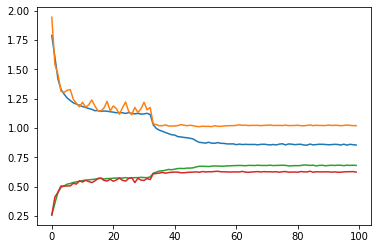

In [13]:
plt.plot(hist), best_acc

In [18]:
model = torch.load('simplenet/VGG_model.pt')
_features = []
_labels = []

# EVALUATE
model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs, features = model(inputs)
    
    with torch.no_grad():
        _features.append(nn.Flatten()(nn.AdaptiveAvgPool2d(output_size=(1,1))(features)).detach().cpu())
        _labels.append(labels.detach().cpu())

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.4f | Avg. val_acc: %.4f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))

- Avg. val_loss: 0.9719 | Avg. val_acc: 0.6356


In [19]:
features = torch.cat(_features).numpy()
labels = torch.cat(_labels).numpy()

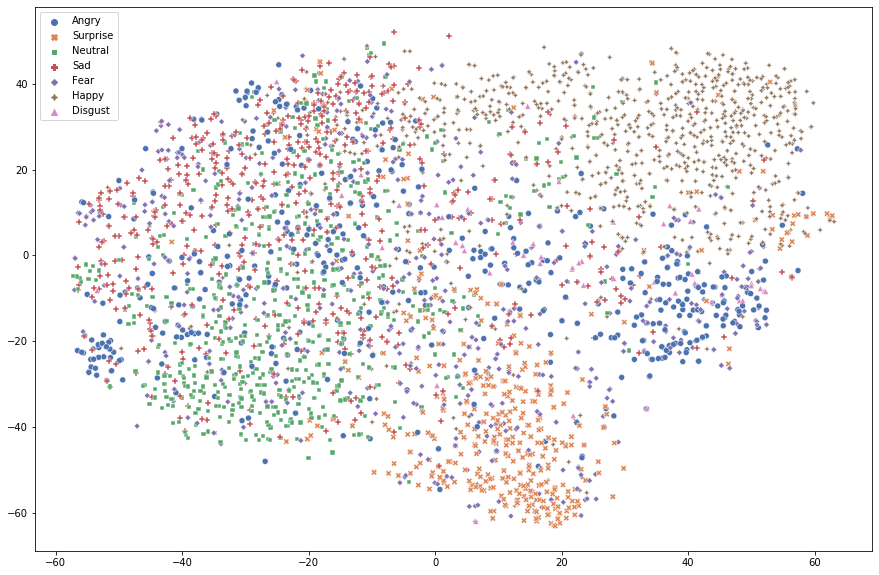

In [20]:
label_dict={0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}
str_labels = [label_dict[int(k)] for k in labels]

from sklearn.manifold import TSNE
tsne_features = TSNE(n_components=2).fit_transform(features)

import seaborn as sns
fig, ax = plt.subplots(figsize=(15,10))
sns.scatterplot(ax=ax, x=tsne_features[:,0], y=tsne_features[:,1], hue=str_labels, style=str_labels, palette="deep")


In [15]:
import torch
from sklearn.metrics import precision_score, recall_score, f1_score

labels = torch.randint(0,7,(12,))
outputs = torch.rand(12,7)
outputs

tensor([[0.9011, 0.6933, 0.2956, 0.3091, 0.4870, 0.3098, 0.2199],
        [0.6511, 0.4254, 0.8805, 0.4672, 0.1952, 0.7951, 0.9267],
        [0.3575, 0.5113, 0.9300, 0.8370, 0.2932, 0.8250, 0.7262],
        [0.4563, 0.0911, 0.4129, 0.4580, 0.2130, 0.6313, 0.3280],
        [0.9621, 0.1953, 0.8569, 0.6879, 0.0452, 0.4151, 0.2543],
        [0.1098, 0.3744, 0.0056, 0.4509, 0.7711, 0.3355, 0.3650],
        [0.8975, 0.9408, 0.3367, 0.2950, 0.3991, 0.1947, 0.4905],
        [0.8256, 0.0967, 0.0503, 0.4718, 0.1569, 0.4439, 0.3331],
        [0.8701, 0.9631, 0.6699, 0.6619, 0.1269, 0.4848, 0.3246],
        [0.4917, 0.2290, 0.3593, 0.5116, 0.2351, 0.2073, 0.4775],
        [0.4904, 0.4911, 0.1931, 0.9507, 0.2649, 0.7120, 0.1630],
        [0.5286, 0.9680, 0.2292, 0.2173, 0.4383, 0.3913, 0.6328]])

In [21]:
avg_precision = precision_score(labels.detach().cpu().numpy(), 
                                        torch.max(outputs, dim=1).indices.detach().cpu().numpy(),
                                        average='macro')

avg_recall = recall_score(labels.detach().cpu().numpy(), 
                                        torch.max(outputs, dim=1).indices.detach().cpu().numpy(),
                                        average='macro')

avg_f1 = f1_score(labels.detach().cpu().numpy(), 
                            torch.max(outputs, dim=1).indices.detach().cpu().numpy(),
                            average='macro')

avg_precision, avg_recall, avg_f1

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.23809523809523808, 0.23809523809523808, 0.19047619047619047)

In [34]:
import numpy as np
hist = np.random.rand(100,4)
hist = np.array(hist).T
hist.shape

(4, 100)

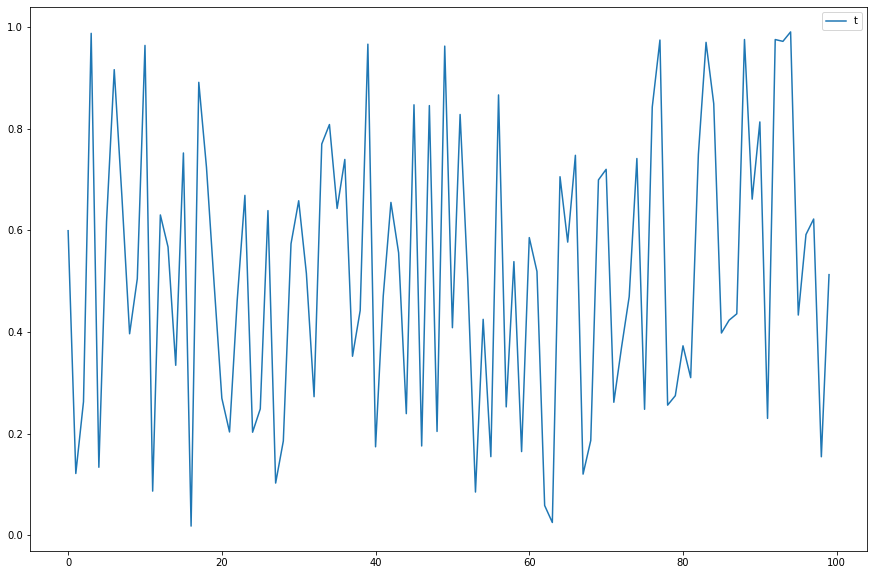

In [29]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(torch.rand(100), label='t')
ax.legend()